## Working with contact in MuJoCo

This chapter introduces how to work with contact in MuJoCo simulations

First we import some basic libraries

In [1]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt
import numpy

The XML file has a couple interesting lines.

In the ```<default>``` tag we see some defaults set for all geoms.  This is one of the easier ways to define contact interactions between all bodies, because it allows us to define parameters globally, and yet tune them locally for particular body/body interactions

```xml
<geom contype="1" conaffinity="1" condim="3" friction=".6 .3 .3" solimp=".99 .99 .01" solref=".001 1" margin="0.001" group="0"/>
```

We also see the line where we set the integrator.  The RK4 integrator is generally going to give us more precise results at the cost of more timesteps (when needed).  The comparison

```xml
<option integrator="RK4"/>
```

additionally, we see that the timestep has been specified.  By changing the timestep, we will be able to understand how this results in varying precision.

```xml
<option timestep="1e-4"/>
```

In [2]:
xml = """
<mujoco>
  <default>
      <light castshadow="false" diffuse="1 1 1"/>
      <camera fovy="45"/>
      <geom contype="1" conaffinity="1" condim="3" friction=".6 .3 .3" solimp=".99 .99 .01" solref=".001 1" margin="0.001" group="0"/>
  </default>
  <option timestep="1e-4"/>
  <option integrator="RK4"/>
  <worldbody>
    <light pos="0 0 10"/>
    <geom name="ground" type="plane" pos="0 0 -.05" size="5 5 .05" rgba=".5 .5 .5 1"/>
    <camera name="target" mode="targetbody" target="body1" pos="0 -5 5" quat=".707 .707 0 0" />
    <body name="body1" pos="1 0 5">
      <joint type="free"/>
      <geom type="box" size=".5 .5 .5" rgba="1 0 0 1"/>
    </body>
    <body name="body2" pos="-1 0 5.5">
      <joint type="free"/>
      <geom type="box" size=".5 .5 .5" rgba="1 0 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""

Create model, data and renderer

In [3]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

Set visualization options to visualize contact locations, force

In [4]:
options = mujoco.MjvOption()
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True


Set various parameters associated with scaling the resultant contact force arrows according to:

<https://mujoco.readthedocs.io/en/stable/XMLreference.html#visual-scale>

In [5]:

model.vis.scale.contactwidth = 0.1
model.vis.scale.contactheight = 0.03
model.vis.scale.forcewidth = 0.05
model.vis.map.force = 0.3

Set model options and other parameters.  In this example, we also pre-define the number of steps to simulate

In [6]:
opt = model.opt
timestep = opt.timestep
fps = 30
duration = 2
model.opt.timestep = timestep
num_steps = int(duration/timestep)

Pre-allocate numpy arrays for holding data

In [7]:
t = []
force1 = numpy.zeros((num_steps,3))
force2 = numpy.zeros((num_steps,3))
wrench = numpy.zeros(6)
frames = []

Set initial conditions

In [8]:
mujoco.mj_resetData(model, data)
data.qvel[0:3] = numpy.array([2,0,0])
data.qvel[3:6] = numpy.array([0,0,1])
data.qvel[6:9] = numpy.array([1,0,0])
data.qvel[9:12] = numpy.array([0,0,0])


Run the simulation.  You can see we add contact forces to the wrench structures only if they belong to the desired geoms

In [ ]:
for ii in range(num_steps):
  mujoco.mj_step(model, data)
  t.append(data.time)
  
  for jj,c in enumerate(data.contact):
        if c.geom1==1 or c.geom2==1:
            mujoco.mj_contactForce(model, data, jj, wrench)
            force1[ii] += wrench[0:3]
        if c.geom1==2 or c.geom2==2:
            mujoco.mj_contactForce(model, data, jj, wrench)
            force2[ii] += wrench[0:3]
  if len(frames) < data.time * fps:
    renderer.update_scene(data,'target',options)
    frame = renderer.render()
    frames.append(frame)
    
t = numpy.array(t)

Show the results

(np.float64(-0.5), np.float64(319.5), np.float64(239.5), np.float64(-0.5))

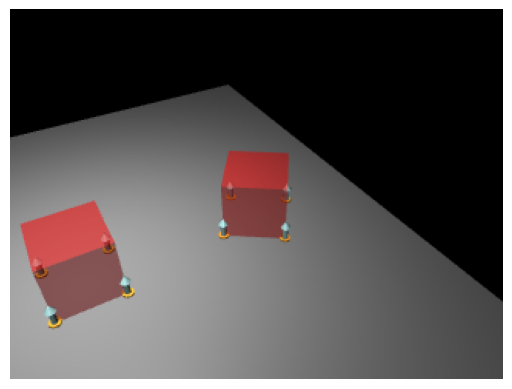

In [13]:
plt.imshow(frames[-1])
plt.axis('off')

Show the video with:

Investigate the structure of the contact class, ```c```

In [10]:
c

<MjContact
  H: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])
  dim: 3
  dist: 0.0009999939962798132
  efc_address: 28
  elem: array([-1, -1], dtype=int32)
  exclude: 0
  flex: array([-1, -1], dtype=int32)
  frame: array([ 0.,  0.,  1.,  0.,  1.,  0., -1.,  0.,  0.])
  friction: array([0.6, 0.6, 0.3, 0.3, 0.3])
  geom: array([0, 2], dtype=int32)
  geom1: 0
  geom2: 2
  includemargin: 0.001
  mu: 0.6
  pos: array([ 0.52035141,  0.5       , -0.0495    ])
  solimp: array([0.99, 0.99, 0.01, 0.5 , 2.  ])
  solref: array([0.001, 1.   ])
  solreffriction: array([0., 0.])
  vert: array([-1, -1], dtype=int32)
>

You can return the sum of forces.

In [11]:
force1[-1:]

array([[ 9.81000000e+03, -7.50333129e-13, -5.45696821e-13]])

Plot the results

Text(0.5, 1.0, 'Contact Force')

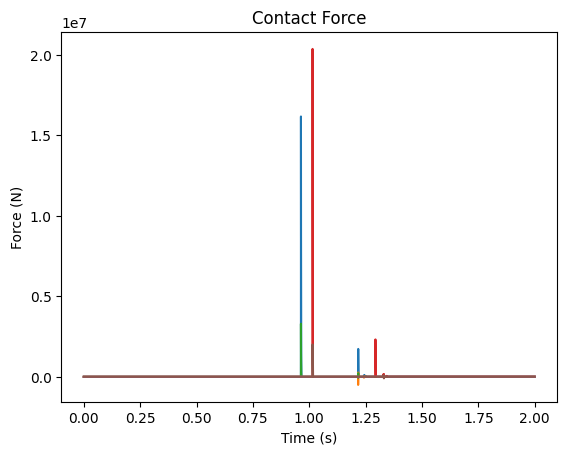

In [12]:
fig = plt.figure()
plt.plot(t, force1)
plt.plot(t, force2)
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.title('Contact Force')

Now try rerunning the example with different contact parameters, timestep, solver, etc.  The results vary widely!